In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="3"

Running Scanpy 1.6.0, on 2021-04-14 17:28.


In [7]:
# adata = sc.read_text('../github_code/Batch-effect-removal-benchmarking/Data/dataset4/myData_pancreatic_5batches.txt').T
# info = pd.read_csv('../github_code/Batch-effect-removal-benchmarking/Data/dataset4/mySample_pancreatic_5batches.txt', sep='\t')
# adata.obs['batch'] = info['batch']
# adata.obs['batchlb'] = info['batchlb']
# adata.obs['celltype'] = info['celltype']

# adata.write_h5ad('data/dataset4.h5ad')

... storing 'batchlb' as categorical
... storing 'celltype' as categorical


In [2]:
adata = sc.read_h5ad('data/dataset4.h5ad')

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=100)

normalizing by total count per cell
    finished (0:00:26): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:20)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:08)


In [3]:
batch_names = adata.obs['batch'].value_counts().index.values
adatas = [adata[adata.obs['batch'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata)
entropy_raw=compute_entropy(adata)

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)
Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'batch' as categorical


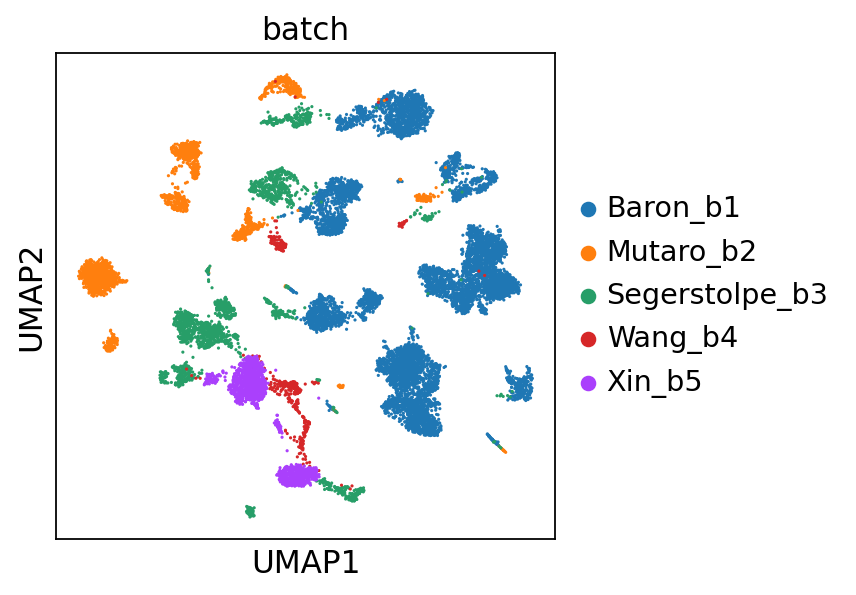

In [5]:
adata.obs['batch'] = adata.obs['batchlb'].tolist()
sc.pl.umap(adata,color='batch',save='_figure5_raw_batch.pdf')

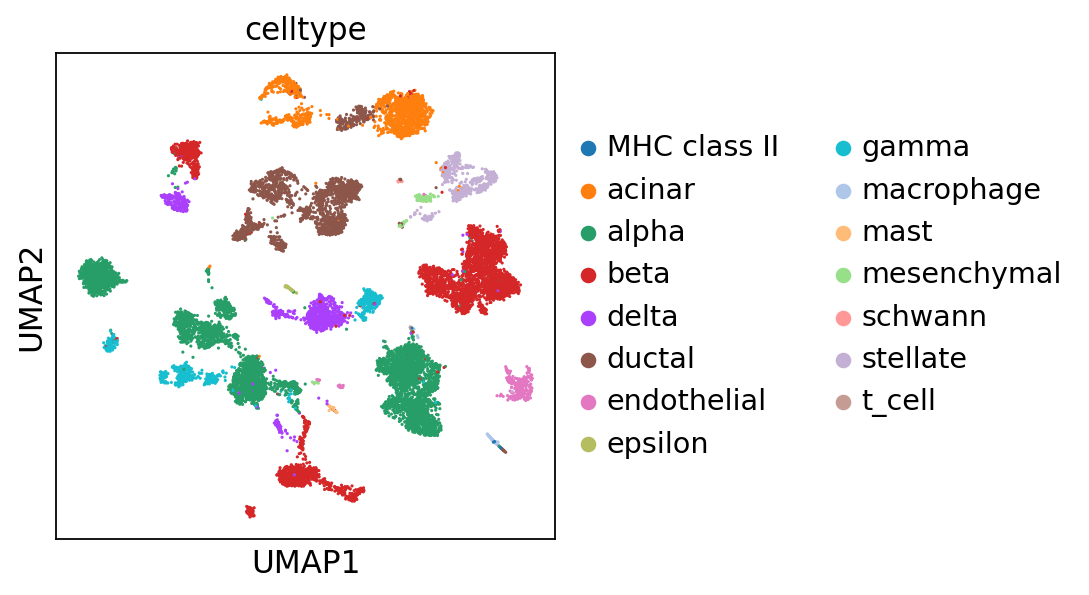

In [6]:
sc.pl.umap(adata,color='celltype',save='_figure5_raw_celltype.pdf')

# Batch correction using deepMNN

In [7]:
time_s = time.time()
corrected = correct_scanpy(adatas, epochs_wo_im=15)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result)
entropy_deepMNN=compute_entropy(adata_result)

[[0.         0.6629055  0.07917059 0.03418231 0.02188184]
 [0.         0.         0.62818096 0.47922252 0.32166302]
 [0.         0.         0.         0.04147031 0.23194748]
 [0.         0.         0.         0.         0.46827133]
 [0.         0.         0.         0.         0.        ]]
Epoch 0, loss: 1119.439, counter: 0
Learning rate = 0.1000000
Epoch 1, loss: 570.287, counter: 0
Learning rate = 0.1000000
Epoch 2, loss: 229.440, counter: 0
Learning rate = 0.1000000
Epoch 3, loss: 143.790, counter: 0
Learning rate = 0.1000000
Epoch 4, loss: 115.939, counter: 0
Learning rate = 0.1000000
Epoch 5, loss: 109.982, counter: 0
Learning rate = 0.1000000
Epoch 6, loss: 93.992, counter: 0
Learning rate = 0.1000000
Epoch 7, loss: 91.687, counter: 0
Learning rate = 0.1000000
Epoch 8, loss: 90.768, counter: 0
Learning rate = 0.1000000
Epoch 9, loss: 92.607, counter: 1
Learning rate = 0.1000000
Epoch 10, loss: 79.019, counter: 0
Learning rate = 0.1000000
Epoch 11, loss: 77.787, counter: 0
Learni

... storing 'batch' as categorical
... storing 'batchlb' as categorical
... storing 'celltype' as categorical


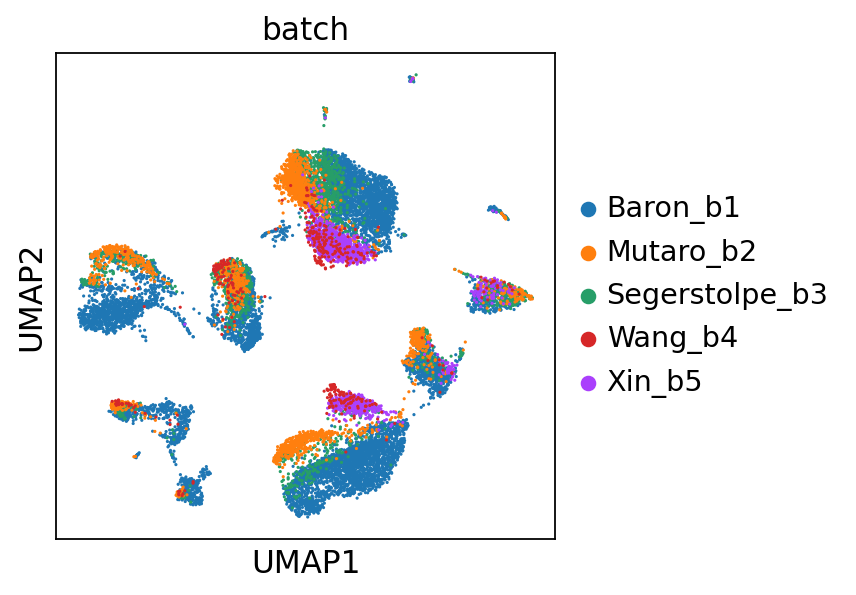

In [8]:
adata_result.obs['batch'] = adata_result.obs['batchlb'].tolist()
sc.pl.umap(adata_result,color='batch',save='_figure5_deepMNN_batch.pdf')

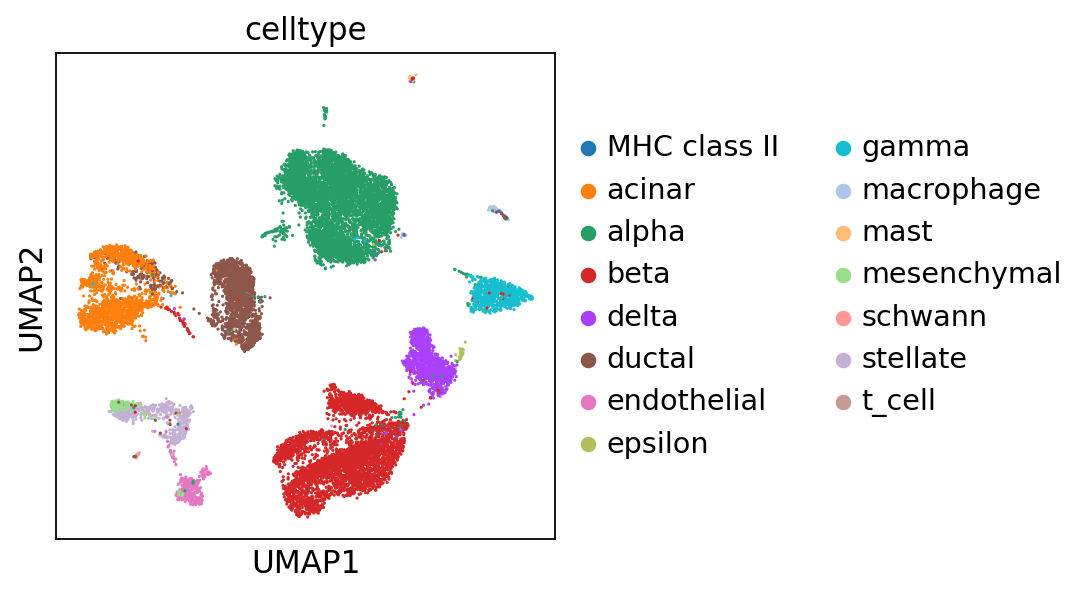

In [9]:
sc.pl.umap(adata_result,color='celltype',save='_figure5_deepMNN_celltype.pdf')

# Batch correction using Scanorama

In [10]:
import scanorama

adata = sc.read_h5ad('data/dataset4.h5ad')
adatas = [adata[adata.obs['batch'] == i,:].copy() for i in [1,2,3,4,5]]

time_s = time.time()
corrected = scanorama.correct_scanpy(adatas)
print('time used:', time.time()-time_s)

corrected_dataset = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch')
sc.tl.pca(corrected_dataset, svd_solver='arpack')
sc.pp.neighbors(corrected_dataset)
sc.tl.umap(corrected_dataset)

asw_Scanorama = silhouette_coeff_ASW(corrected_dataset)
entropy_Scanorama=compute_entropy(corrected_dataset)

Found 15558 genes among all datasets
[[0.         0.31055608 0.33239304 0.06345733 0.27882038]
 [0.         0.         0.50634697 0.21444201 0.01273458]
 [0.         0.         0.         0.82713348 0.38605898]
 [0.         0.         0.         0.         0.21581769]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (2, 4)
Processing datasets (0, 2)
Processing datasets (0, 1)
Processing datasets (0, 4)
Processing datasets (3, 4)
Processing datasets (1, 3)
time used: 996.4133200645447
computing PCA
    with n_comps=50
    finished (0:09:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
Calculating entropy ...
use exist neighbors
Entropy ca

... storing 'batch' as categorical
... storing 'batchlb' as categorical
... storing 'celltype' as categorical


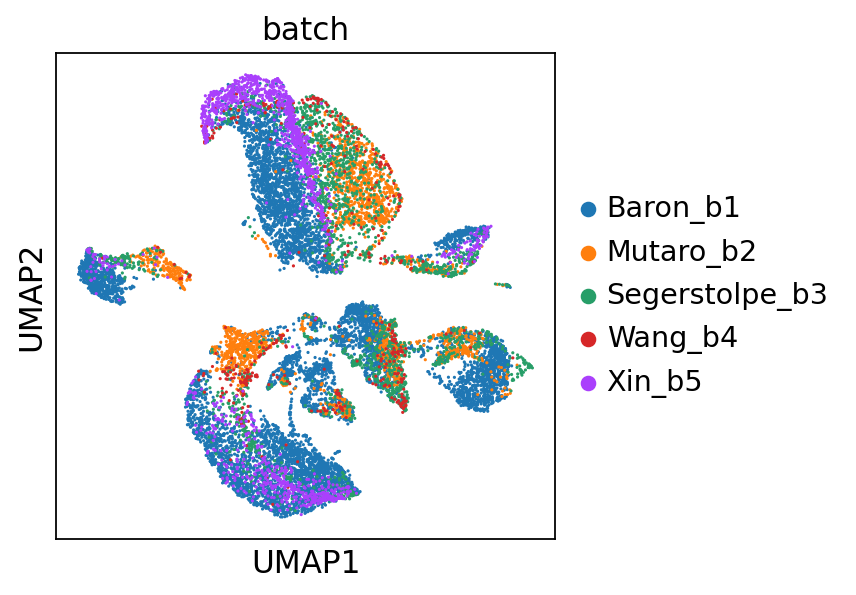

In [11]:
corrected_dataset.obs['batch'] = corrected_dataset.obs['batchlb'].tolist()
sc.pl.umap(corrected_dataset,color='batch',save='_figure5_Scanorama_batch.pdf')

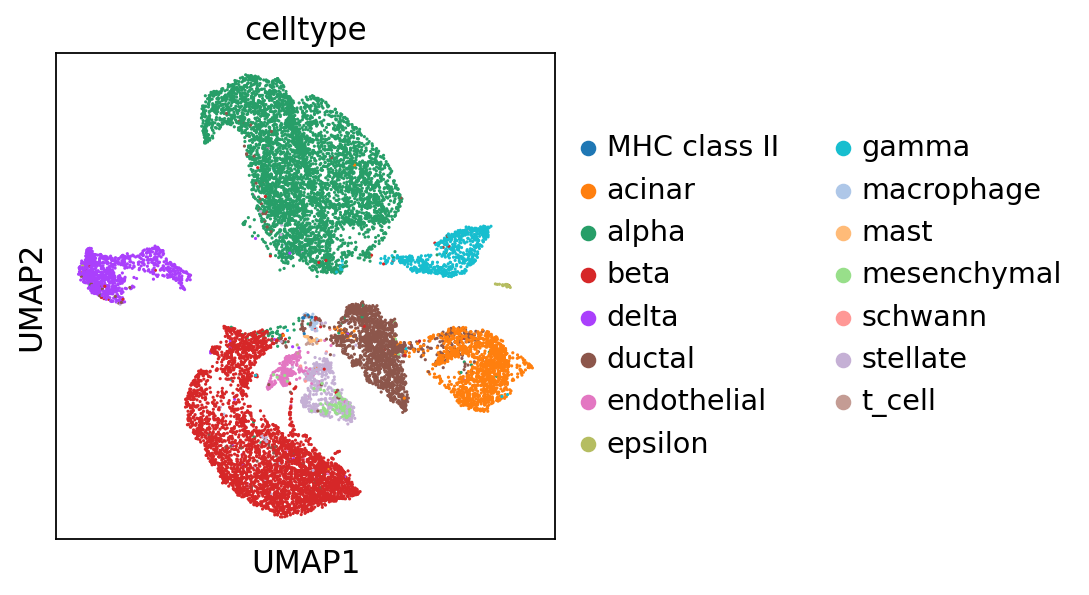

In [12]:
sc.pl.umap(corrected_dataset,color='celltype',save='_figure5_Scanorama_celltype.pdf')

# Metrics

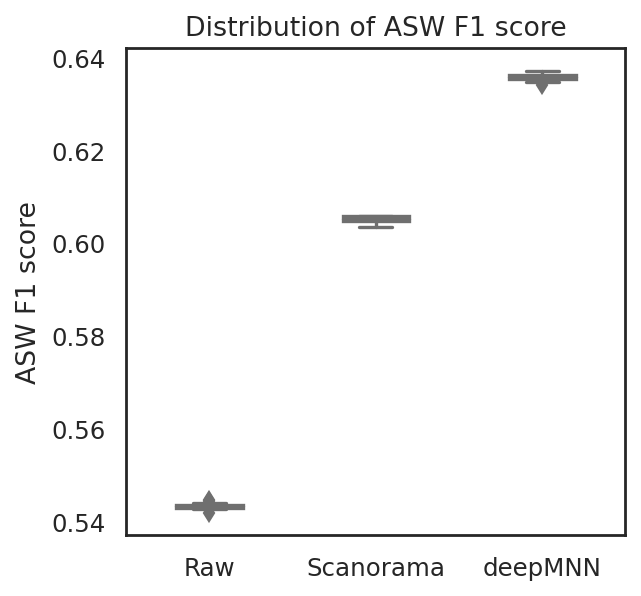

In [13]:
asw_df = pd.DataFrame()
asw_df['ASW F1 score'] = asw_raw['fscore'].tolist() + asw_Scanorama['fscore'].tolist() + asw_deepMNN['fscore'].tolist()
asw_df['Methods'] = (['Raw'] * asw_raw.shape[0] + 
                     ['Scanorama'] * asw_raw.shape[0] + 
                     ['deepMNN'] * asw_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette='pastel')
sns.boxplot(x='Methods', y='ASW F1 score', width=0.4, data=asw_df)
plt.title('Distribution of ASW F1 score')
plt.xlabel('')
plt.savefig('figures/ASW_F1_score_figure5.pdf', format='pdf', dpi=300, bbox_inches='tight')

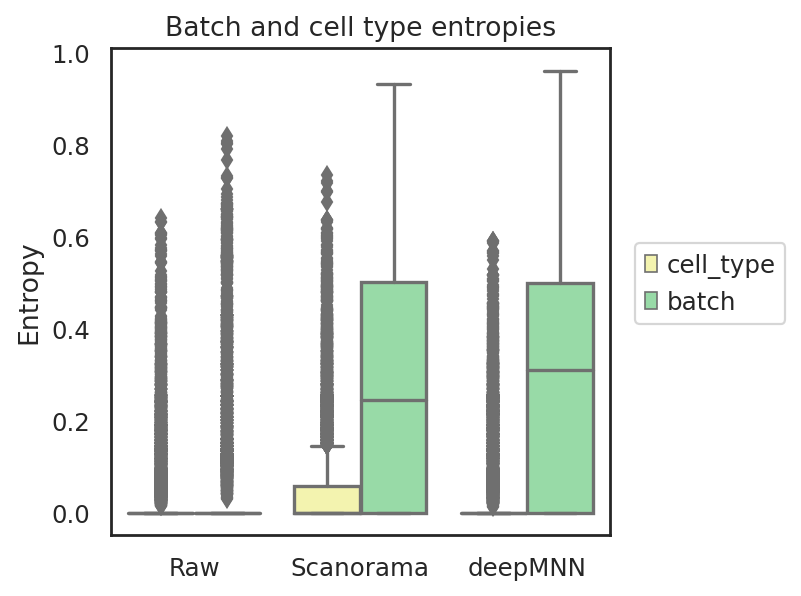

In [14]:
entropy_df = pd.DataFrame()
entropy_df['Entropy'] = (entropy_raw['cell_type'].tolist() + entropy_raw['batch'].tolist() + 
                         entropy_Scanorama['cell_type'].tolist() + entropy_Scanorama['batch'].tolist() + 
                         entropy_deepMNN['cell_type'].tolist() + entropy_deepMNN['batch'].tolist())
entropy_df['Methods'] = (['Raw'] * entropy_raw.shape[0] * 2 + 
                         ['Scanorama'] * entropy_raw.shape[0] * 2 + 
                         ['deepMNN'] * entropy_raw.shape[0] * 2)
entropy_df['Entropy_type'] = (['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0] + 
                              ['cell_type'] * entropy_raw.shape[0] + ['batch'] * entropy_raw.shape[0])

# plt.figure(dpi=300)

sns.set_theme(style='white', palette="pastel")

sns.boxplot(x='Methods', y='Entropy',
            hue='Entropy_type', palette=['y', 'g'], data=entropy_df)
plt.title('Batch and cell type entropies')
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 0.6), borderaxespad=0)
plt.savefig('figures/Entropy_figure5.pdf', format='pdf', dpi=300, bbox_inches='tight')